# **Import Libraries and modules**

In [0]:
# https://keras.io/
!pip install -q keras
import keras

# New Section

In [0]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist

### Load pre-shuffled MNIST data into train and test sets

In [4]:
(trainX, trainy), (testX, testy) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


### reshape dataset to have a single channel

In [5]:
width, height, channels = trainX.shape[1], trainX.shape[2], 1
print(width, height, channels)

28 28 1


In [0]:
trainX = trainX.reshape((trainX.shape[0], width, height, channels))
testX = testX.reshape((testX.shape[0], width, height, channels))


### Convert 1-dimensional class arrays to 10-dimensional class matrices


In [0]:
#hold original y in variable to figure out miss values later on
original_testy = testy

trainy = np_utils.to_categorical(trainy, 10)
testy = np_utils.to_categorical(testy, 10)

### report pixel means and standard deviations

In [8]:
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

Statistics train=33.318 (78.567), test=33.791 (79.172)


### create generator that centers pixel values

In [9]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen

### calculate the mean on the training dataset

In [10]:
datagen.fit(trainX)
print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

Data Generator mean=33.318, std=78.567


### demonstrate effect on a single batch of samples

In [11]:
iterator = datagen.flow(trainX, trainy, batch_size=64)
iterator

### get a batch

In [0]:
batchX, batchy = iterator.next()

### pixel stats in the batch

In [13]:
print(batchX.shape, batchX.mean(), batchX.std())

(64, 28, 28, 1) 0.01317222 1.0139471


### demonstrate effect on entire training dataset

In [14]:
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)
iterator

In [15]:
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.regularizers import l2

model = Sequential()
# Extract edges and gradients features
model.add(Convolution2D(10, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', input_shape=(28,28,1))) #26
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Trying to extract more features by increasing channels 
model.add(Convolution2D(16, (3, 3),  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='relu')) #24
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(10, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')) #22

# reducing the size of parameters
model.add(MaxPooling2D(pool_size=(2, 2))) #11

# Since we have done  MP above we should try using 1x1 and fetch co dependend features.
model.add(Convolution2D(16, (1, 1), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')) #11
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(16, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')) #9
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(16, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')) #7
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(16, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')) #5
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(16, (3,3))) #3
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(10, (3,3))) 

model.add(Flatten())
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 10)        100       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 10)        40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        1456      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 10)        1450      
__________

### Train the model

In [17]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

# checkpoint

filepath="model_accuracy.best.hdf5"

reduce_LR = LearningRateScheduler(scheduler, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#callbacks_list = [reduce_LR, checkpoint]

model.fit(trainX, trainy, batch_size=128, epochs=40, verbose=1, validation_data=(testX, testy), callbacks=[reduce_LR, checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
60000/60000 [==============================] - 11s 186us/step - loss: 0.5755 - acc: 0.9284 - val_loss: 0.2653 - val_acc: 0.9547

Epoch 00001: val_acc improved from -inf to 0.95470, saving model to model_accuracy.best.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
60000/60000 [==============================] - 7s 115us/step - loss: 0.1690 - acc: 0.9729 - val_loss: 0.1556 - val_acc: 0.9732

Epoch 00002: val_acc improved from 0.95470 to 0.97320, saving model to model_accuracy.best.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
60000/60000 [==============================] - 7s 115us/step - loss: 0.1374 - acc: 0.9772 - val_loss: 0.1163 - val_acc: 0.9830

Epoch 00003: val_acc improved from 0.97320 to 0.98300, saving model to model_

In [0]:
score = model.evaluate(testX, testy, verbose=0)

In [19]:
print(score)

[0.03216355375647545, 0.9937]


### Wrongly predicted data

In [0]:


predicted_classes = model.predict(testX)

#See which we predicted correctly and which not

correct_indices = np.nonzero(predicted_classes == testy)[0] 
incorrect_indices = np.nonzero(predicted_classes != testy)[0] 

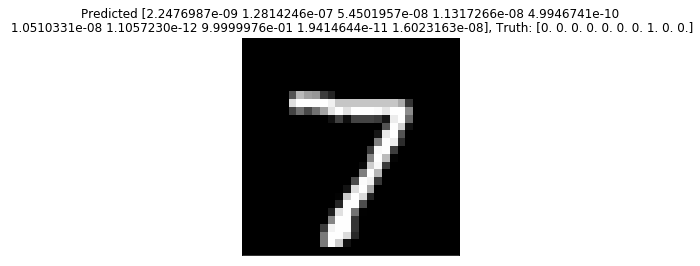

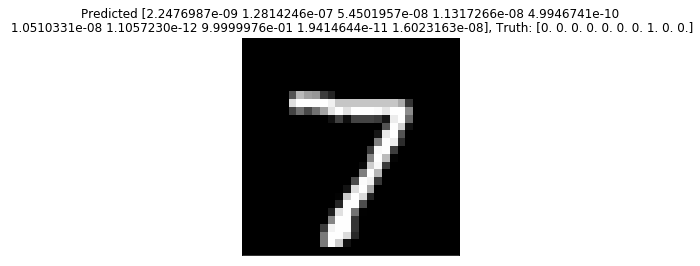

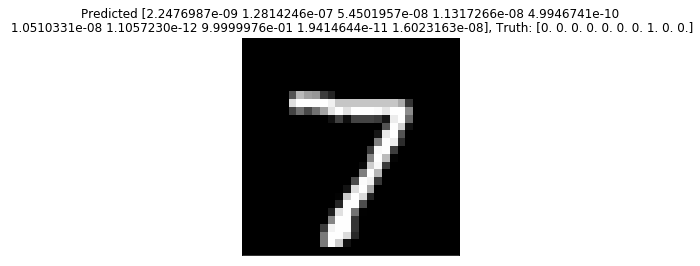

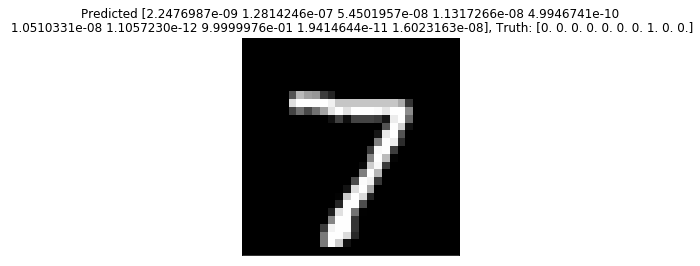

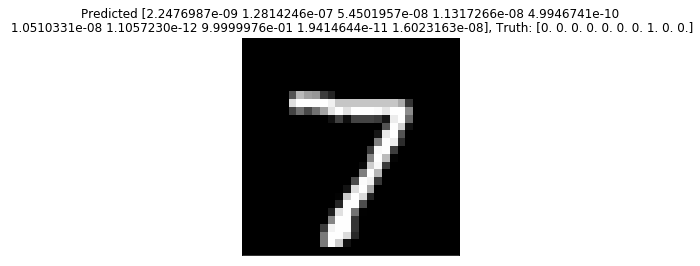

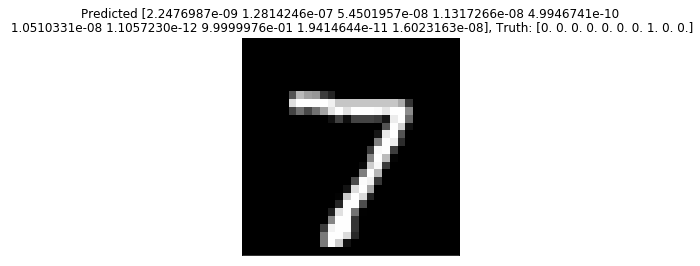

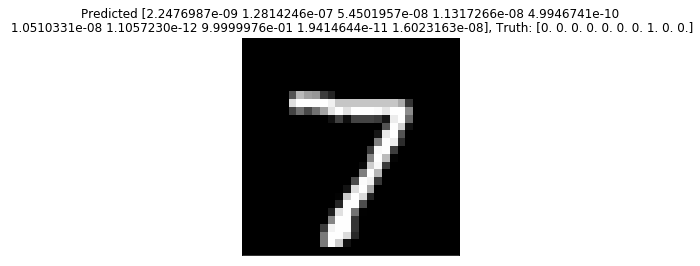

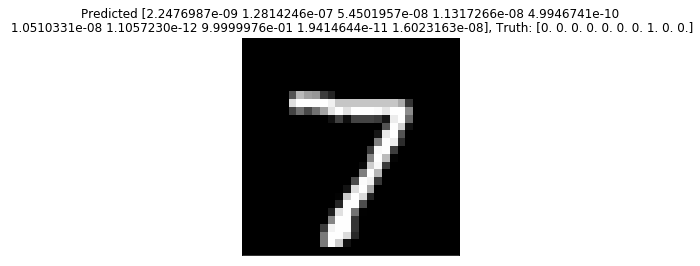

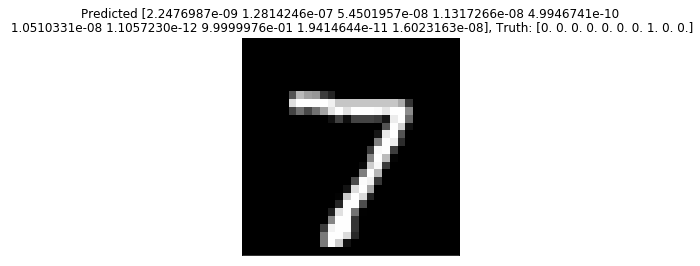

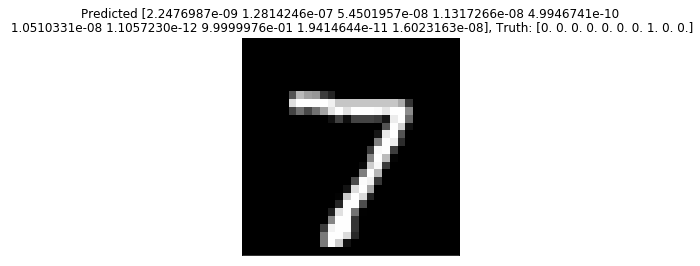

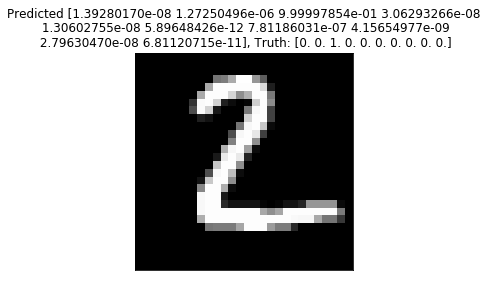

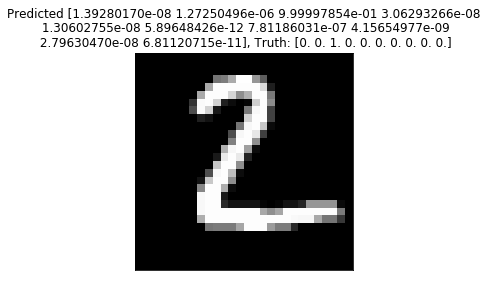

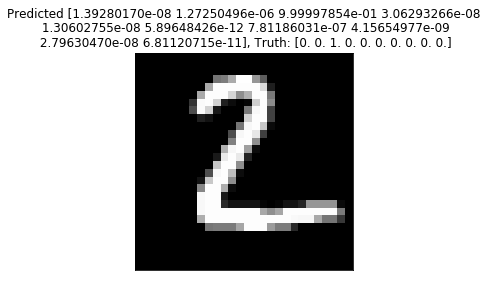

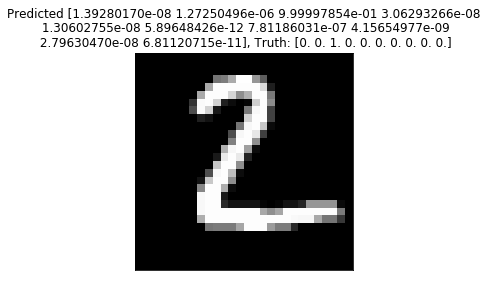

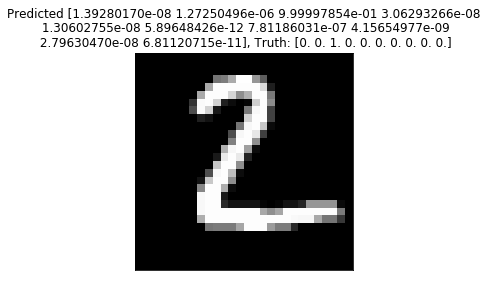

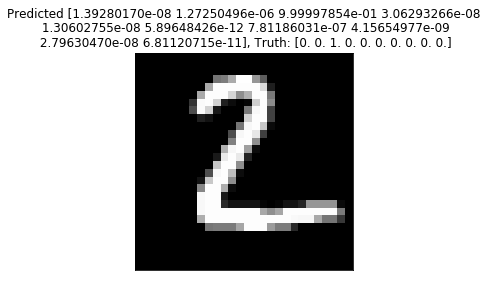

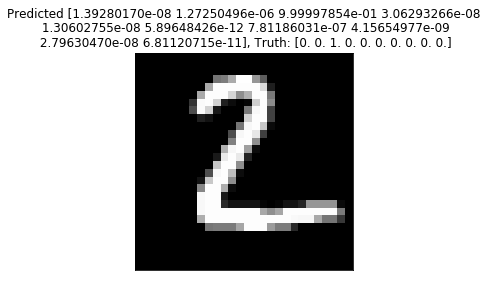

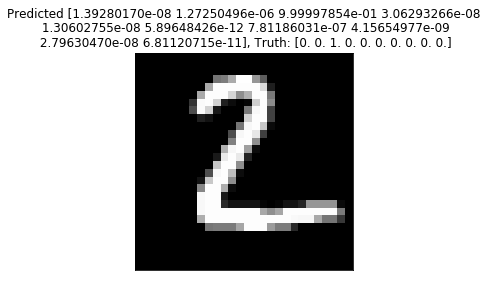

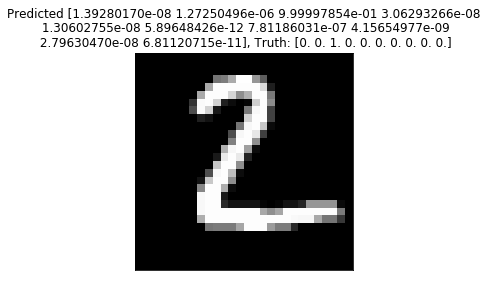

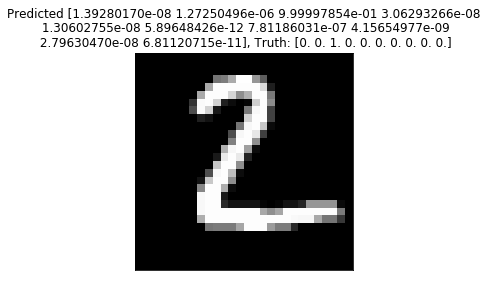

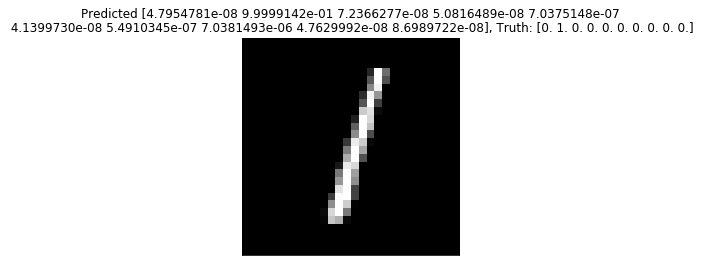

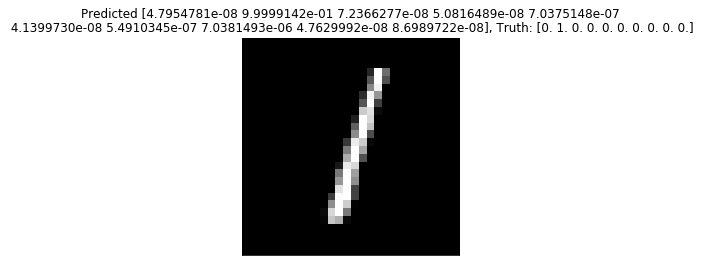

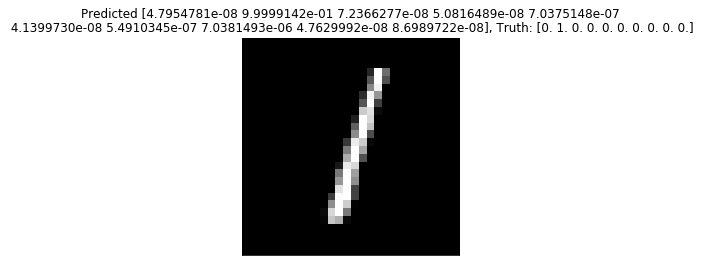

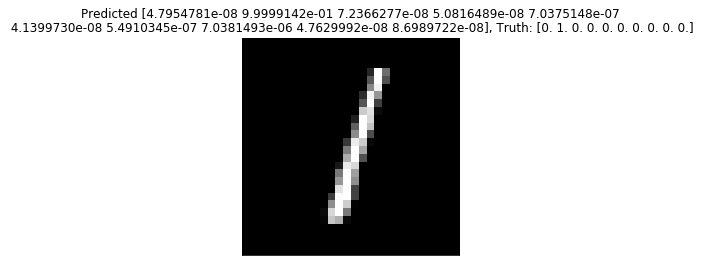

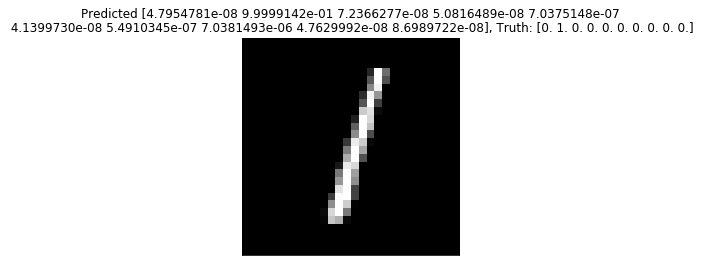

In [25]:
import matplotlib.pyplot as plt
# plot 25 incorrect predictions

for i, incorrect in enumerate(incorrect_indices[:25]):

  plt.imshow(testX[incorrect].reshape(28,28), cmap='gray', interpolation='none')

  plt.title( "Predicted {}, Truth: {}".format(predicted_classes[incorrect], testy[incorrect]))

  plt.xticks([])

  plt.yticks([])

  plt.show()

In [0]:
y_pred = model.predict(testX)

In [27]:
print(y_pred[:9])
print(testy[:9])

[[2.24769869e-09 1.28142460e-07 5.45019567e-08 1.13172662e-08
  4.99467412e-10 1.05103313e-08 1.10572304e-12 9.99999762e-01
  1.94146435e-11 1.60231632e-08]
 [1.39280170e-08 1.27250496e-06 9.99997854e-01 3.06293266e-08
  1.30602755e-08 5.89648426e-12 7.81186031e-07 4.15654977e-09
  2.79630470e-08 6.81120715e-11]
 [4.79547815e-08 9.99991417e-01 7.23662765e-08 5.08164888e-08
  7.03751482e-07 4.13997299e-08 5.49103447e-07 7.03814931e-06
  4.76299924e-08 8.69897221e-08]
 [9.99407172e-01 2.75214185e-10 4.57082962e-07 5.35621147e-08
  3.89122690e-08 6.49579897e-06 5.56331594e-04 5.63809088e-08
  9.82288293e-06 1.95673165e-05]
 [3.31276051e-09 2.65400479e-09 4.14844513e-11 6.88844218e-13
  9.99996305e-01 2.61528993e-10 4.41784813e-08 5.16529042e-09
  4.61364294e-07 3.20955382e-06]
 [1.57338107e-08 9.99993443e-01 2.23538521e-08 4.57328353e-09
  4.57394719e-07 6.61158106e-09 2.11088221e-07 5.79817060e-06
  3.77180456e-08 1.06963888e-07]
 [2.01440448e-10 1.84820976e-06 6.11838913e-10 1.30608805e